In [45]:
# General
import numpy
import os

# Processing
import pandas as pd

# Drawing
import cartopy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io import shapereader
from matplotlib.cm import get_cmap
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [46]:
# Data from: https://www.scotland.police.uk/about-us/covid-19-police-scotland-response/enforcement-and-response-data/

raw_data = pd.read_excel(os.path.join(os.getcwd(), 'datasets', 'coronavirus-enforcement-information-to-9-june-2021.xlsx'), sheet_name=1)
raw_data.drop(['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17'], axis=1, inplace=True)

In [47]:
# Taking account of NaNs
# Explanation:
# The xlsx to pandas dataframe conversion seems to have taken "NA" for a division "N" and an Area Command "Inverness"
# and interpret that "NA" as actually: "NaN". Which is very annoying. So the below overwrites the SD letter of area commands
# that are inverness and turns them back to "NA"
raw_data.loc[raw_data["Area Commands"] == "Inverness", "SD Letter"] = raw_data["SD Letter"].fillna("NA")

In [48]:
if (raw_data.isnull().sum().sum() != 0):
    raise ValueError("We have NaNs in our dataframe")


In [49]:
division_grouped = raw_data.groupby('Division Letter', as_index=False
                                ).agg(
                                {"Asked / Informed": "sum",
                                "Warned / Instructed": "sum",
                                "Removed from Place or Premises": "sum",
                                "FPN": "sum",
                                "Arrested": "sum",
                                })

In [50]:
# Data from: https://www.nrscotland.gov.uk/statistics-and-data/statistics/statistics-by-theme/population/population-estimates/mid-year-population-estimates/mid-2019

raw_pop_data = pd.read_csv(os.path.join(os.getcwd(), 'datasets', 'Population', 'mid-year-pop-est-19-data_Table 2.csv'))
# Keep only the specific columns
raw_pop_data = raw_pop_data[['Unnamed: 1','Unnamed: 2']]
# Rename them inplace
raw_pop_data.rename(columns={'Unnamed: 1': 'Council areas', 'Unnamed: 2': 'Population'}, inplace=True)
# Drop upper rows that are bad
raw_pop_data = raw_pop_data.drop(raw_pop_data.index[[0,1,2,3,4]]).reset_index(drop=True)
# Drop from certain row, minus 1 for the row above position
raw_pop_data = raw_pop_data[:(raw_pop_data[raw_pop_data['Council areas'] == 'NHS Board areas'].index[0] - 1)]
# Strip out all the commas in Objects of the Population column
raw_pop_data["Population"].replace(',','', regex=True, inplace=True)
# Convert string to int
raw_pop_data["Population"] = raw_pop_data["Population"].astype(str).astype(int)

In [51]:
# We group the council areas into our police divisions
# First, set our index
raw_pop_data.set_index('Council areas')
# Create our division dictionary
div_dict = {'A': ["Moray", "Aberdeenshire", "Aberdeen City"],
            'C': ["Stirling", "Clackmannanshire", "Falkirk"],
            'D': ["Angus", "Dundee City", "Perth and Kinross"],
            'E': ["City of Edinburgh"],
            'G': ["East Renfrewshire", "Glasgow City", "East Dunbartonshire"],
            'J': ["Scottish Borders", "East Lothian", "Midlothian", "West Lothian"],
            'K': ["Inverclyde", "Renfrewshire"],
            'L': ["Argyll and Bute", "West Dunbartonshire"],
            'N': ["Na h-Eileanan Siar", "Orkney Islands", "Highland", "Shetland Islands"],
            'P': ["Fife"],
            'Q': ["South Lanarkshire", "North Lanarkshire"],
            'U': ["South Ayrshire", "East Ayrshire", "North Ayrshire"],
            'V': ["Dumfries and Galloway"]
            }

div_pop = {}

def divisionPopulation(row):
    incomingRow = row.tolist()

    for div, councils in div_dict.items():
        for council in councils:
            if (council == incomingRow[0]):
                if div in div_pop:
                    div_pop[div] += incomingRow[1]
                else:
                    div_pop[div] = incomingRow[1]

raw_pop_data.apply(lambda row: divisionPopulation(row), axis=1)

div_pop_data = pd.DataFrame(div_pop.items(), columns=['Division Letter', 'Population'])

In [52]:
division_data = pd.merge(division_grouped, div_pop_data, on='Division Letter')

division_data['Asked / Informed per 100k'] = division_data.apply (lambda row: row['Asked / Informed']/(row['Population'] / 100000) if row['Population'] > 0 else 0, axis=1)
division_data['Warned / Instructed per 100k'] = division_data.apply (lambda row: row['Warned / Instructed']/(row['Population'] / 100000) if row['Population'] > 0 else 0, axis=1)
division_data['Removed from Place or Premises per 100k'] = division_data.apply (lambda row: row['Removed from Place or Premises']/(row['Population'] / 100000) if row['Population'] > 0 else 0, axis=1)
division_data['FPN per 100k'] = division_data.apply (lambda row: row['FPN']/(row['Population'] / 100000) if row['Population'] > 0 else 0, axis=1)
division_data['Arrested per 100k'] = division_data.apply (lambda row: row['Arrested']/(row['Population'] / 100000) if row['Population'] > 0 else 0, axis=1)

In [53]:
# code for a scale bar and north arrow

from math import floor
from matplotlib import patheffects
import matplotlib
if os.name == 'nt':
    matplotlib.rc('font', family='Arial')
else:  # might need tweaking, must support black triangle for N arrow
    matplotlib.rc('font', family='DejaVu Sans')

def utm_from_lon(lon):
    """
    utm_from_lon - UTM zone for a longitude

    Not right for some polar regions (Norway, Svalbard, Antartica)

    :param float lon: longitude
    :return: UTM zone number
    :rtype: int
    """
    return floor( ( lon + 180 ) / 6) + 1

def scale_bar(ax, proj, length, location=(0.5, 0.05), linewidth=3,
              units='km', m_per_unit=1000):
    """

    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    # buffer for scalebar
    buffer = [patheffects.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, path_effects=buffer)
    # buffer for text
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    # Plot the scalebar label
    t0 = ax.text(sbcx, sbcy, str(length) + ' ' + units, transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    left = x0+(x1-x0)*0.05
    # Plot the N arrow
    t1 = ax.text(left, sbcy, u'\u25B2\nN', transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    # Plot the scalebar without buffer, in case covered by text buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, zorder=3)



In [54]:
# Creating new figure and axes instances
def enforcementOutcome(outcome_type):
    fig = plt.figure(figsize=(6,8), dpi=100)
    projectionPARAM = ccrs.TransverseMercator(central_longitude=-2.0, central_latitude=49.0, false_easting=400000.0, false_northing=-100000.0, scale_factor=0.9996012717, approx=False)
    ax = fig.add_subplot(1, 1, 1, projection=projectionPARAM)
    ax.set_extent([-8, 0, 54.5, 61]) # Ideal coordinate map range for plotting Scotland

    police_dict = (division_data[['Division Letter', outcome_type]].set_index('Division Letter').T.to_dict('records'))[0]

    # Downloaded from: https://spatialdata.gov.scot/geonetwork/srv/eng/catalog.search;jsessionid=61F713CF39B3EE2F440F48E9C31BA806#/metadata/4364af71-167a-4236-b5a0-bd4109913231
    area_file = os.path.join(os.getcwd(), 'datasets', 'ScottishPoliceDivisions', 'SG_ScottishPoliceDivisions_2019.shp')
    police_divisions = shapereader.Reader(area_file)

    norm = colors.Normalize(vmin=0., vmax=max(police_dict.values()))
    cmap = get_cmap('PuBu')

    for record in police_divisions.records():
        code = record.attributes['AdminCode']
        police_entry = police_dict.get(code, -1)
        if police_entry == -1:
            police_color = "Silver"
        else:
            police_color = cmap(police_entry/max(police_dict.values()))
        ax.add_geometries(
                [record.geometry],
                #facecolor=numpy.random.rand(3,),
                facecolor=police_color,
                linewidth=0,
                crs=projectionPARAM,
        )

    # following https://matplotlib.org/2.0.2/mpl_toolkits/axes_grid/users/overview.html#colorbar-whose-height-or-width-in-sync-with-the-master-axes
    # we need to set axes_class=plt.Axes, else it attempts to create
    # a GeoAxes as colorbar

    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)

    fig.add_axes(ax_cb)

    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    cb = plt.colorbar(sm, cax=ax_cb)
    cb.set_label(outcome_type + " of Population")

    scale_bar(ax, projectionPARAM, 100, location=(0.85, 0.05))  # 100 km scale bar

    plt.plot()

###
# Copyright Scottish Government, contains Ordnance Survey data © Crown copyright and database right (2021)
###

/home/callum/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f9147c6c5e0> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


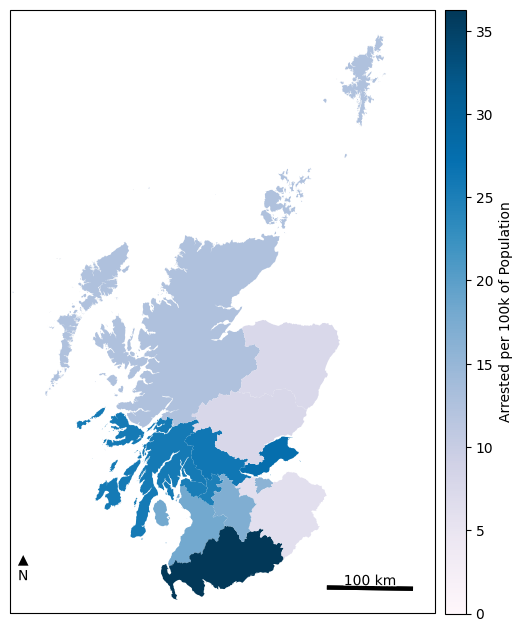

In [55]:
enforcementOutcome('Arrested per 100k')